# Transpiler

qiskit.transpiler

https://quantum.cloud.ibm.com/docs/en/api/qiskit/transpiler

https://quantum.cloud.ibm.com/docs/en/guides/transpiler-stages

Transpilation is the process of rewriting a given input circuit to match the topology of a specific quantum device, and/or to optimize the circuit for execution on quantum systems.

Most circuits must undergo a series of transformations that make them compatible with a given target device, and optimize them to reduce the effects of noise on the resulting outcomes. 

Rewriting quantum circuits to match hardware constraints and optimizing for performance can be far from trivial. 

The flow of logic in the rewriting tool chain need not be linear, and can often have iterative sub-loops, conditional branches, and other complex behaviors. 

That being said, the standard compilation flow follows the structure given below:

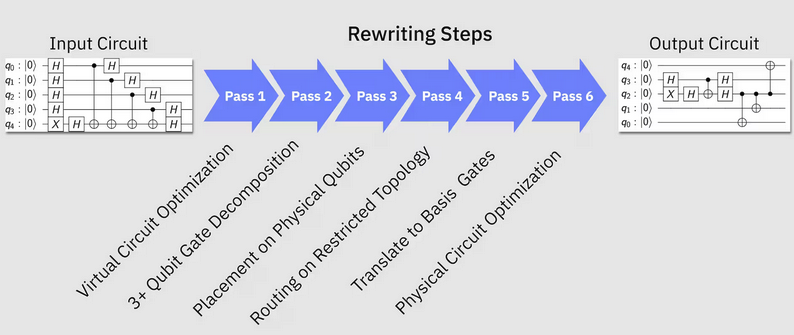

## Stages

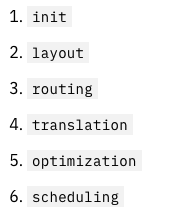

## Init stage

This first stage does very little by default and is primarily useful if you want to include your own initial optimizations. 

Because most layout and routing algorithms are only designed to work with single- and two-qubit gates, this stage is also used to translate any gates that operate on more than two qubits, into gates that only operate on one or two qubits.

## Layout stage

The next stage involves the layout or connectivity of the backend a circuit will be sent to. 

In general, quantum circuits are abstract entities whose qubits are "virtual" or "logical" representations of actual qubits used in computations. 

To execute a sequence of gates, a one-to-one mapping from the "virtual" qubits to the "physical" qubits in an actual quantum device is necessary. 

This mapping is stored as a Layout object and is part of the constraints defined within a backend's instruction set architecture (ISA).

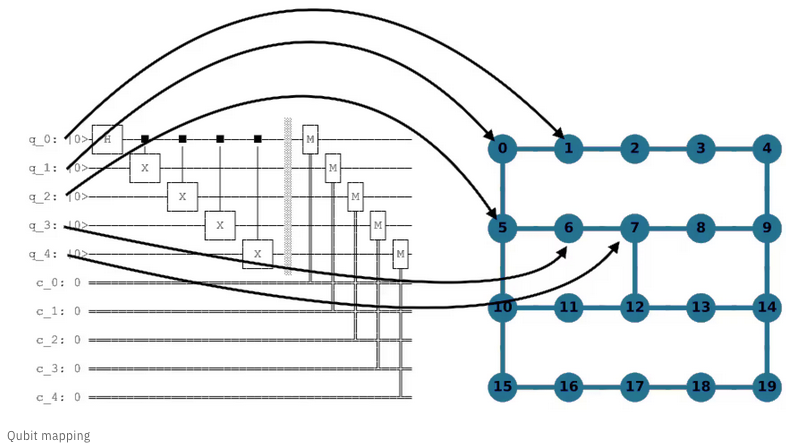

## Routing stage

In order to implement a two-qubit gate between qubits that are not directly connected on a quantum device, one or more SWAP gates must be inserted into the circuit to move the qubit states around until they are adjacent on the device gate map. 

Each SWAP gate represents an expensive and noisy operation to perform. Thus, finding the minimum number of SWAP gates needed to map a circuit onto a given device is an important step in the transpilation process. For efficiency, this stage is typically computed alongside the Layout stage by default, but they are logically distinct from one another. 

**The Layout stage selects the hardware qubits to be used, while the Routing stage inserts the appropriate amount of SWAP gates in order to execute the circuits using the selected layout.**

However, finding the optimal SWAP mapping is hard. In fact, it is an NP-hard problem, and is thus prohibitively expensive to compute for all but the smallest quantum devices and input circuits. To work around this, Qiskit uses a stochastic heuristic algorithm called SabreSwap to compute a good, but not necessarily optimal, SWAP mapping. The use of a stochastic method means that the circuits generated are not guaranteed to be the same over repeated runs. Indeed, running the same circuit repeatedly results in a distribution of circuit depths and gate counts at the output. 

It is for this reason that many users choose to run the routing function (or the entire StagedPassManager) many times and select the lowest-depth circuits from the distribution of outputs.

### Example:

In [1]:
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit
from qiskit_ibm_runtime.fake_provider import FakeAuckland, FakeWashingtonV2
from qiskit.transpiler import generate_preset_pass_manager
 
backend = FakeAuckland()

Greenberger-Horne-Zeilinger (GHZ) state is a specific type of entangled quantum state involving three or more qubits. 

Equivalent to a Bell-State for more Qubits.

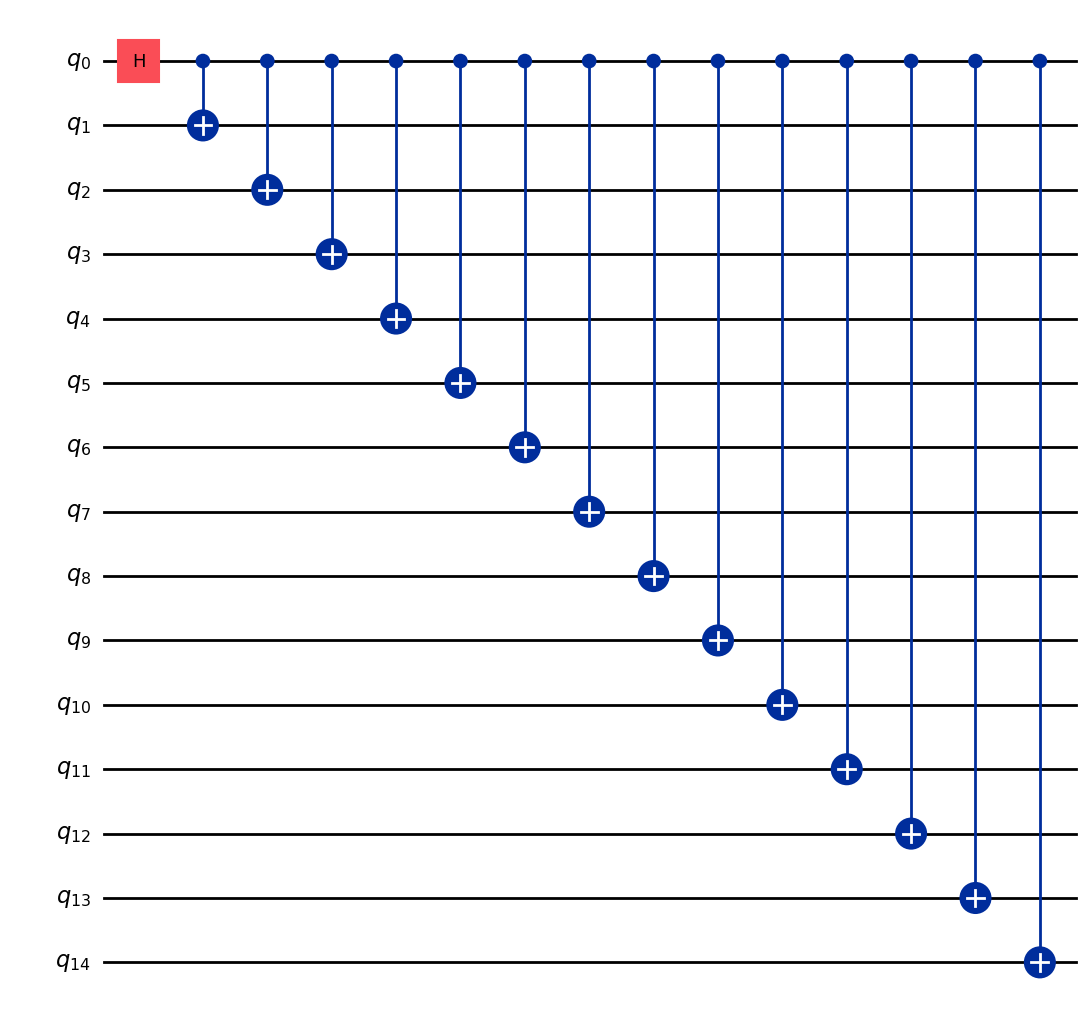

In [2]:
ghz = QuantumCircuit(15)
ghz.h(0)
ghz.cx(0, range(1, 15))
 
ghz.draw("mpl", idle_wires=False)

Text(0, 0.5, 'Counts')

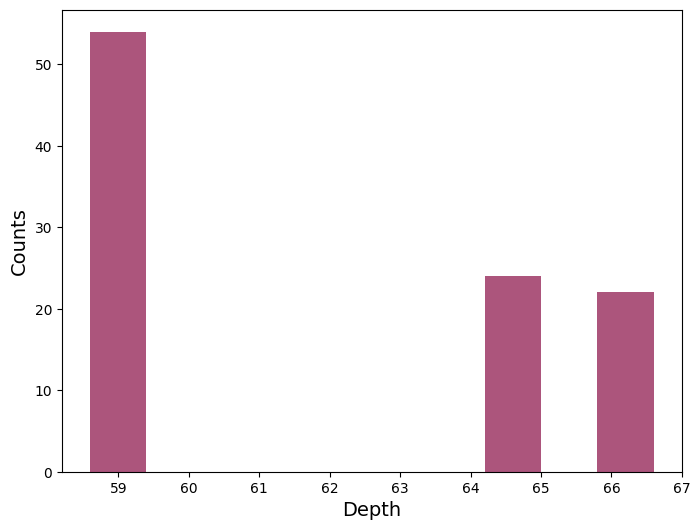

In [3]:
depths = []

for seed in range(100):
    pass_manager = generate_preset_pass_manager(
        optimization_level=1,
        backend=backend,
        layout_method="trivial",  # Fixed layout mapped in circuit order
        seed_transpiler=seed,  # For reproducible results
    )
    depths.append(pass_manager.run(ghz).depth())
 
plt.figure(figsize=(8, 6))
plt.hist(depths, align="left", color="#AC557C")
plt.xlabel("Depth", fontsize=14)
plt.ylabel("Counts", fontsize=14)

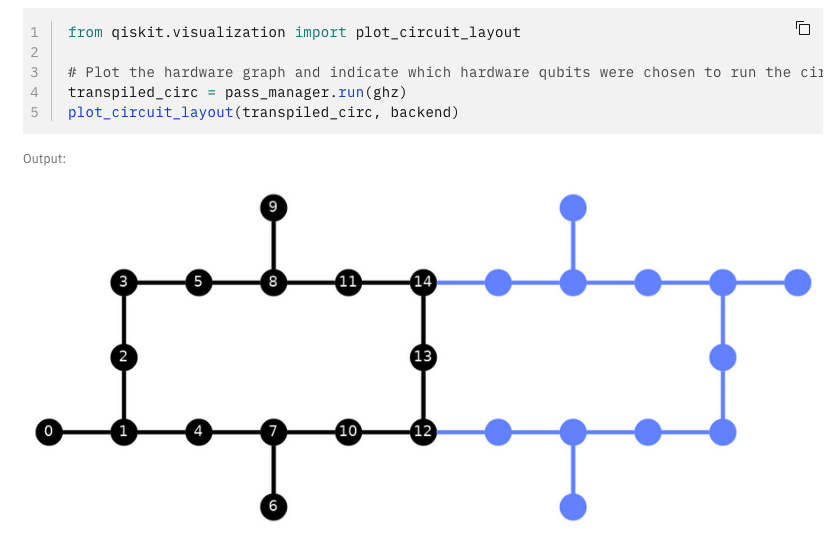

As you can see, this circuit has to execute a two-qubit gate between qubits 0 and 14, which are very far apart on the connectivity graph. Running this circuit thus requires inserting SWAP gates to execute all of the two-qubit gates using the SabreSwap pass.

## Translation stage
When writing a quantum circuit, you are free to use any quantum gate (unitary operation) that you like, along with a collection of non-gate operations such as qubit measurement or reset instructions. 

However, most quantum devices only natively support a handful of quantum gate and non-gate operations. 

These native gates are part of the definition of a target's ISA and this stage of the preset PassManagers translates (or unrolls) the gates specified in a circuit to the native basis gates of a specified backend. 

This is an important step, as it allows the circuit to be executed by the backend, but typically leads to an increase in the depth and number of gates.

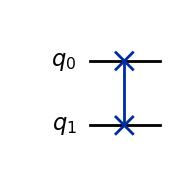

In [4]:
qc = QuantumCircuit(2)
qc.swap(0, 1)
qc.draw("mpl")

The SWAP gate takes two qubits as input and swaps their states. For example, if the first qubit is in state |0⟩ and the second is in state |1⟩, after applying the SWAP gate, the first qubit will be in state |1⟩ and the second will be in state |0⟩.

native gates:['cx', 'delay', 'for_loop', 'id', 'if_else', 'measure', 'reset', 'rz', 'switch_case', 'sx', 'x']


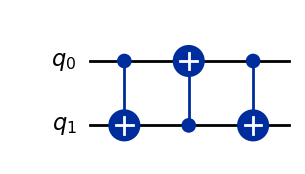

In [5]:
print("native gates:" + str(sorted(backend.operation_names)))

qc = QuantumCircuit(2)
qc.swap(0, 1)
qc.decompose().draw("mpl")

The Toffoli gate, also known as the Controlled-Controlled-NOT (CCNOT) gate, is a fundamental component in quantum computing. It operates on three qubits: two control qubits and one target qubit. The target qubit is flipped (inverted) only if both control qubits are in the state 1. If either control qubit is 0, the target qubit remains unchanged.

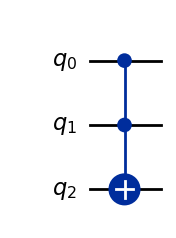

In [6]:
qc = QuantumCircuit(3)
qc.ccx(0, 1, 2)
qc.draw("mpl")

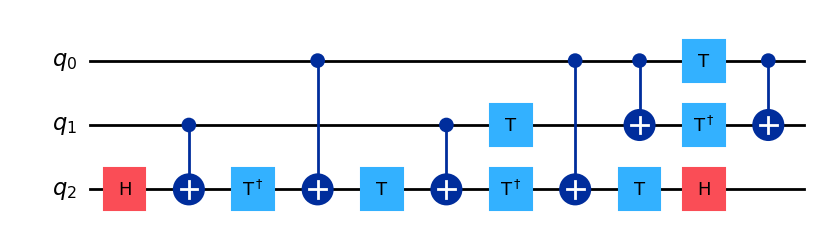

In [7]:
qc = QuantumCircuit(3)
qc.ccx(0, 1, 2)
qc.decompose().draw("mpl")

## Optimization stage
This stage centers around decomposing quantum circuits into the basis gate set of the target device, and must fight against the increased depth from the layout and routing stages. 

Fortunately, there are many routines for optimizing circuits by either combining or eliminating gates. 

In some cases, these methods are so effective that the output circuits have lower depth than the inputs, even after layout and routing to the hardware topology. 

In other cases, not much can be done, and the computation may be difficult to perform on noisy devices. This stage is where the various optimization levels begin to differ.

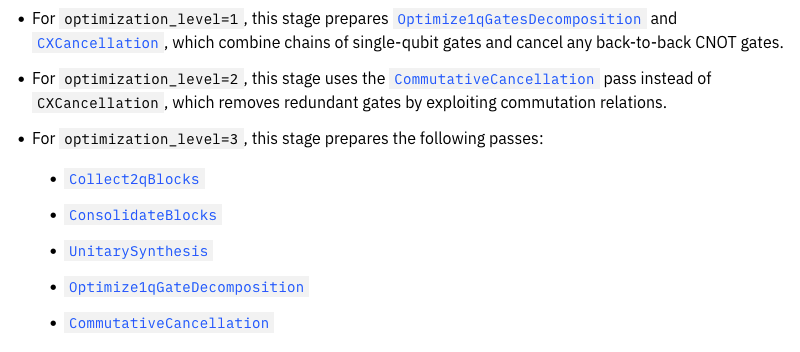

The following code constructs a 15-qubit GHZ state and compares the optimization_levels of transpilation in terms of resulting circuit depth, gate counts, and multi-qubit gate counts.

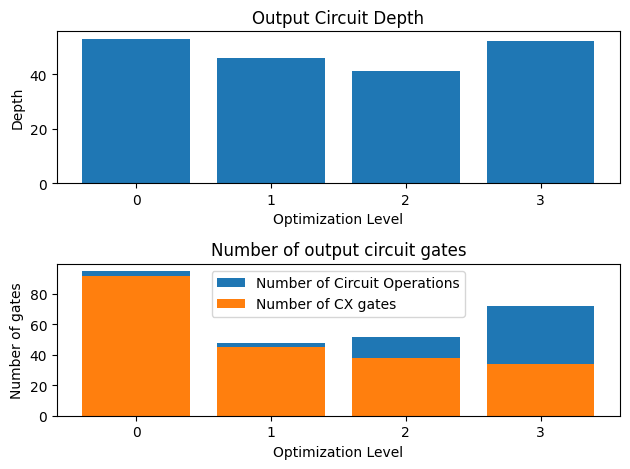

In [8]:
ghz = QuantumCircuit(15)
ghz.h(0)
ghz.cx(0, range(1, 15))
 
depths = []
gate_counts = []
multiqubit_gate_counts = []
levels = [str(x) for x in range(4)]
for level in range(4):
    pass_manager = generate_preset_pass_manager(
        optimization_level=level,
        backend=backend,
        seed_transpiler=1234,
    )
    circ = pass_manager.run(ghz)
    depths.append(circ.depth())
    gate_counts.append(sum(circ.count_ops().values()))
    multiqubit_gate_counts.append(circ.count_ops()["cx"])
 
fig, (ax1, ax2) = plt.subplots(2, 1)
ax1.bar(levels, depths, label="Depth")
ax1.set_xlabel("Optimization Level")
ax1.set_ylabel("Depth")
ax1.set_title("Output Circuit Depth")
ax2.bar(levels, gate_counts, label="Number of Circuit Operations")
ax2.bar(levels, multiqubit_gate_counts, label="Number of CX gates")
ax2.set_xlabel("Optimization Level")
ax2.set_ylabel("Number of gates")
ax2.legend()
ax2.set_title("Number of output circuit gates")
fig.tight_layout()
plt.show()

## Scheduling
This last stage is only run if it is explicitly called for (similar to the Init stage) and does not run by default (though a method can be specified by setting the scheduling_method argument when calling generate_preset_pass_manager). 

The scheduling stage is typically used once the circuit has been translated to the target basis, mapped to the device, and optimized. 

These passes focus on accounting for all the idle time in a circuit. 

At a high level, the scheduling pass can be thought of as explicitly inserting delay instructions to account for the idle time between gate executions and to inspect how long the circuit will be running on the backend.

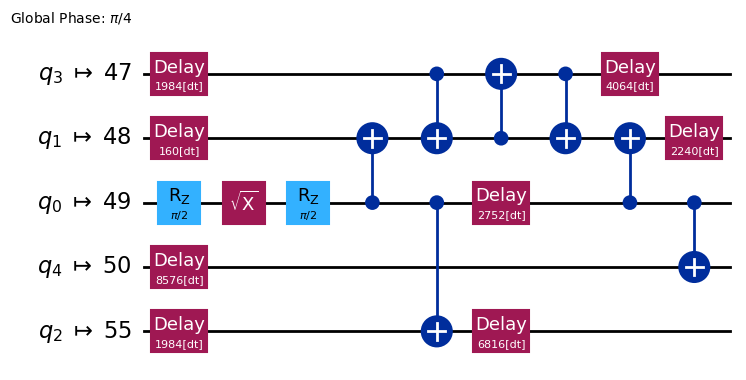

In [9]:
ghz = QuantumCircuit(5)
ghz.h(0)
ghz.cx(0, range(1, 5))
 
 
# Use fake backend
backend = FakeWashingtonV2()
 
# Run with optimization level 3 and 'asap' scheduling pass
pass_manager = generate_preset_pass_manager(
    optimization_level=3,
    backend=backend,
    scheduling_method="asap",
    seed_transpiler=1234,
)
 
 
circ = pass_manager.run(ghz)
circ.draw(output="mpl", idle_wires=False)